In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pprint import pprint
import os.path as pth

import gzip
import pickle

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Flatten, Reshape
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split, KFold, GroupKFold

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
ROOT_DIR = '../data'
TRAIN_IMG_DIR = pth.join(ROOT_DIR, 'original/train_images')
TRAIN_DATA_DIR = ROOT_DIR

WIDTH=1600
HEIGHT=256

In [4]:
data = pd.read_feather(pth.join(TRAIN_DATA_DIR, 'train.feather'))

/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
data.head()

,imageid,classid,mask_present
0,0002cc93b,1,True
1,0002cc93b,2,False
2,0002cc93b,3,False
3,0002cc93b,4,False
4,00031f466,1,False


In [6]:
with gzip.open(pth.join(TRAIN_DATA_DIR, 'train_masks.pickle.gz'), 'rb') as f:
    image_masks = pickle.load(f)

from loaders import BlockwiseImageLoader
n = 4
b = BlockwiseImageLoader(train_cv_image_names[0:10], image_groups, image_masks, n, 128, 64)
img_patches, mask_patches = b[0]
imgs = b.combine_patches(img_patches)

for i in range(n):
    name = train_cv_image_names[i]
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')[:, :, 0]
    plt.figure()
    plt.imshow(im, cmap='gray')
    plt.show()
    plt.figure()
    plt.imshow(imgs[i], cmap='gray')
    plt.show()


In [26]:
from models import SimpleAE, SimpleInception

model = SimpleAE(64)
model.build_model()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 1600, 1 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 1600, 16 160         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 1600, 16 2320        conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 256, 1600, 16 2320        conv2d_40[0][0]                  
____________________________________________________________________________________________

In [27]:
image_groups = data.groupby('imageid')

image_names = list(data.imageid.unique())[0:1000]
train_cv_image_names, test_image_names = train_test_split(image_names)
len(train_cv_image_names), len(test_image_names)

(750, 250)

In [28]:
from loaders import ImageLoader, BlockwiseImageLoader

BATCH_SIZE = 4
PATCH_SIZE = 64
PATCH_STRIDE = 32

kfold = KFold(2)

for train_indices, cv_indices in kfold.split(train_cv_image_names):
    train_image_names = [train_cv_image_names[i] for i in train_indices]
    cv_image_names = [train_cv_image_names[i] for i in cv_indices]
    print(f'{len(train_image_names)} training samples, {len(cv_image_names)} validation samples')
    model.fit_generator(
        generator=ImageLoader(train_image_names, image_groups, image_masks, 
                              BATCH_SIZE),#, PATCH_SIZE, PATCH_STRIDE),
        validation_data=ImageLoader(cv_image_names, image_groups, image_masks, 
                                    BATCH_SIZE),#, PATCH_SIZE, PATCH_STRIDE),
        epochs=5)

375 training samples, 375 validation samples
Epoch 1/5
94/94 [==============================] - 23s 247ms/step - loss: 0.2075 - conv2d_42_loss: 0.0173 - conv2d_44_loss: 0.0028 - conv2d_46_loss: 0.1138 - conv2d_48_loss: 0.0736 - val_loss: 0.2115 - val_conv2d_42_loss: 0.0117 - val_conv2d_44_loss: 0.0045 - val_conv2d_46_loss: 0.1148 - val_conv2d_48_loss: 0.0805
Epoch 2/5
94/94 [==============================] - 20s 216ms/step - loss: 0.1984 - conv2d_42_loss: 0.0160 - conv2d_44_loss: 0.0019 - conv2d_46_loss: 0.1105 - conv2d_48_loss: 0.0700 - val_loss: 0.2107 - val_conv2d_42_loss: 0.0117 - val_conv2d_44_loss: 0.0045 - val_conv2d_46_loss: 0.1139 - val_conv2d_48_loss: 0.0805
Epoch 3/5
94/94 [==============================] - 20s 214ms/step - loss: 0.1985 - conv2d_42_loss: 0.0160 - conv2d_44_loss: 0.0019 - conv2d_46_loss: 0.1106 - conv2d_48_loss: 0.0700 - val_loss: 0.2107 - val_conv2d_42_loss: 0.0117 - val_conv2d_44_loss: 0.0045 - val_conv2d_46_loss: 0.1139 - val_conv2d_48_loss: 0.0805
Epoch 4

In [29]:
model.model.history.history.keys()

dict_keys(['loss', 'conv2d_42_loss', 'conv2d_44_loss', 'conv2d_46_loss', 'conv2d_48_loss', 'val_loss', 'val_conv2d_42_loss', 'val_conv2d_44_loss', 'val_conv2d_46_loss', 'val_conv2d_48_loss'])

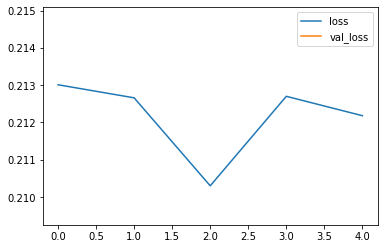

In [30]:
def plot_history(history, keys=['loss', 'val_loss']):
    if len(keys) == 0:
        return
    
    n = 3
    primary = np.array(history[keys[0]])
    ymin = primary.mean() - primary.std() * n
    ymax = primary.mean() + primary.std() * n
    
    plt.figure()
    plt.ylim(ymin, ymax)
    for key in keys:
        if key in history.keys():
            plt.plot(history[key], label=key)
        else:
            print(f'Unable to plot {key}')
    plt.legend()
    plt.show()
    
plot_history(model.model.history.history)
    

In [31]:
names = test_image_names[0:10]
loader = ImageLoader(names, image_groups, image_masks,
                     BATCH_SIZE)#, PATCH_SIZE, PATCH_STRIDE)
results = model.predict_generator(generator=loader)
#results = loader.combine_mask_patches(results)

124204a30


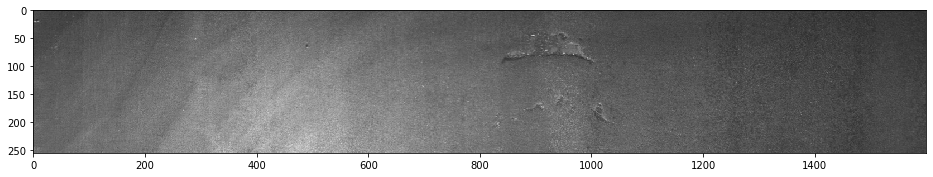

124204a30 1 REF


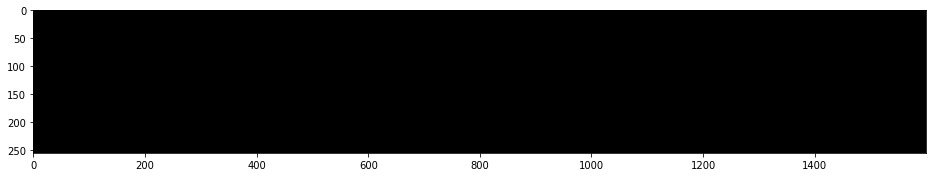

124204a30 1 TEST 0


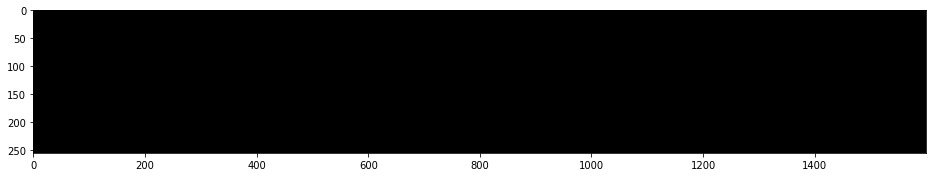

124204a30 2 REF


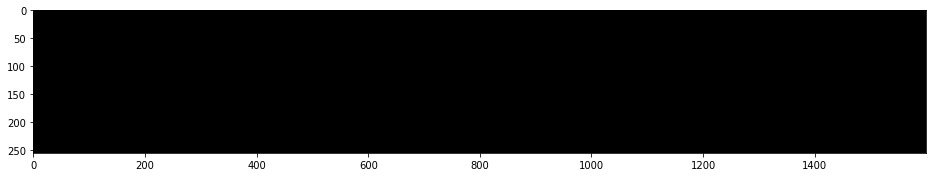

124204a30 2 TEST 0


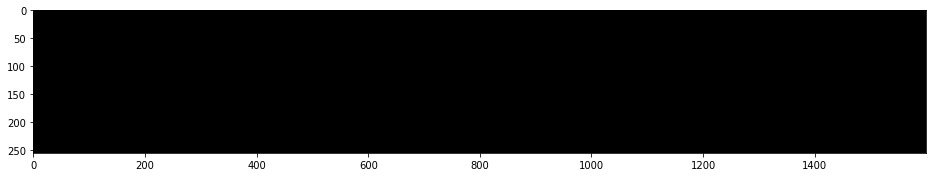

124204a30 3 REF


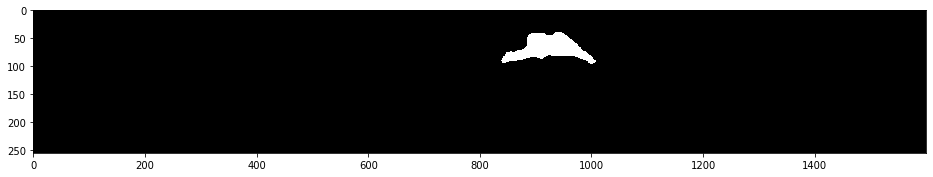

124204a30 3 TEST 409596


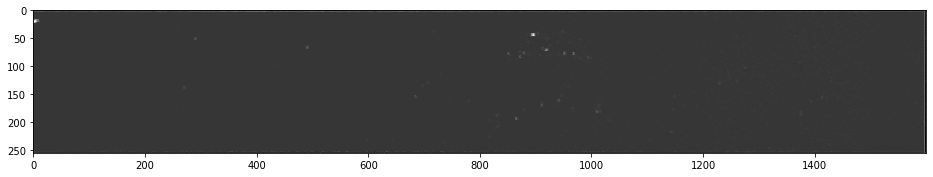

124204a30 4 REF


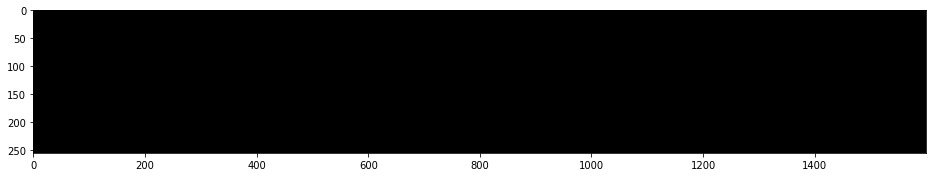

124204a30 4 TEST 0


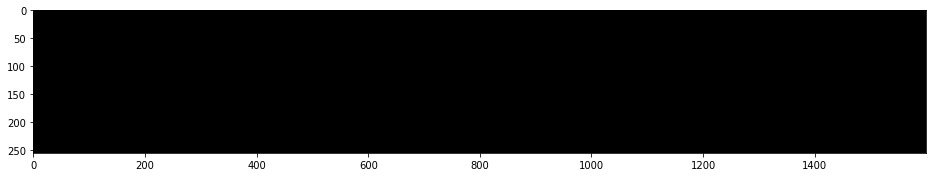

001d1b355


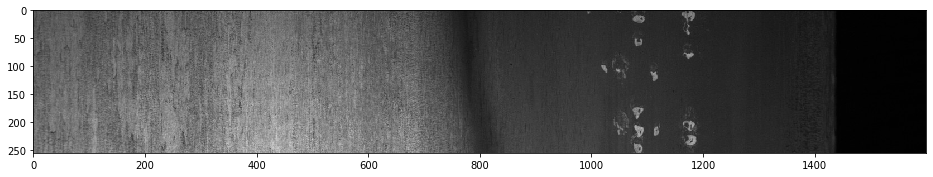

001d1b355 1 REF


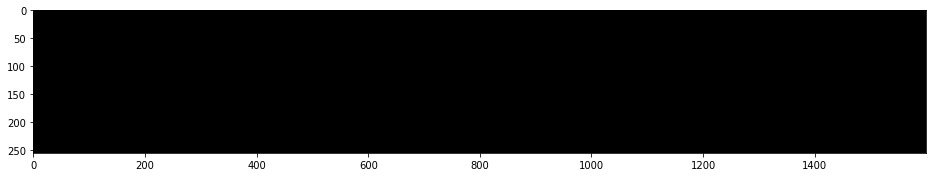

001d1b355 1 TEST 0


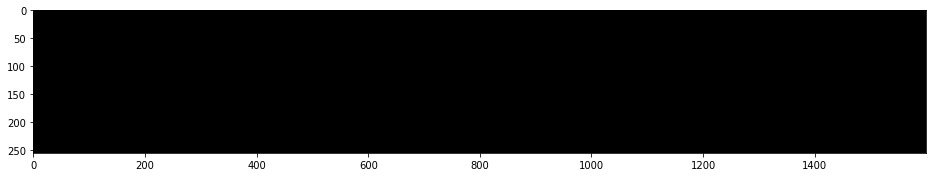

001d1b355 2 REF


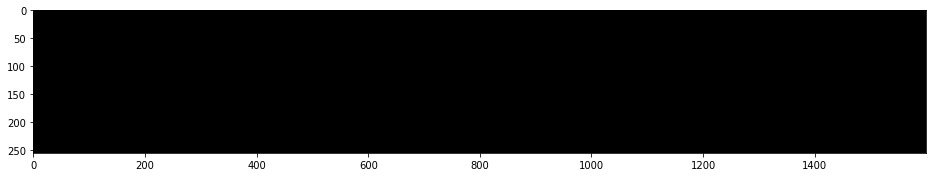

001d1b355 2 TEST 0


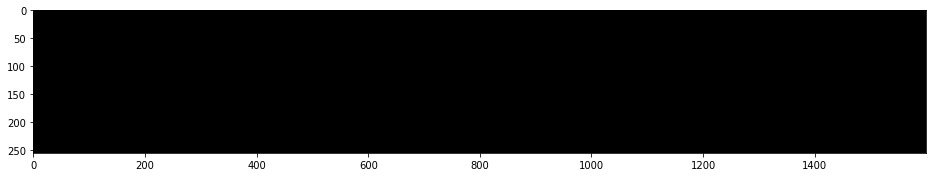

001d1b355 3 REF


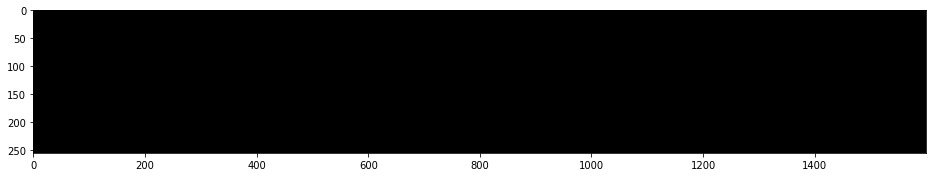

001d1b355 3 TEST 368262


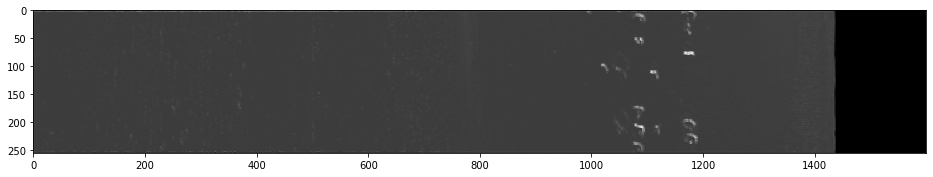

001d1b355 4 REF


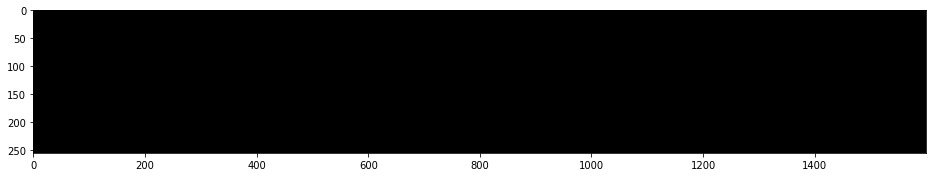

001d1b355 4 TEST 0


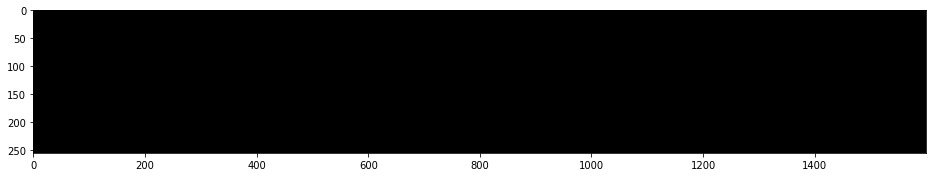

02d3ca489


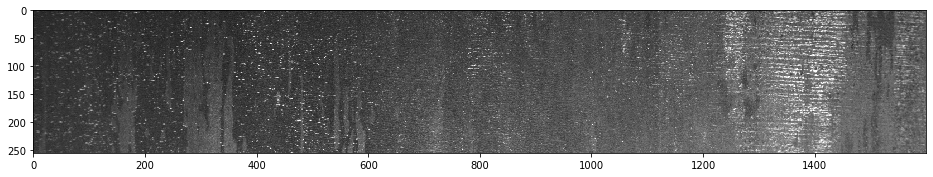

02d3ca489 1 REF


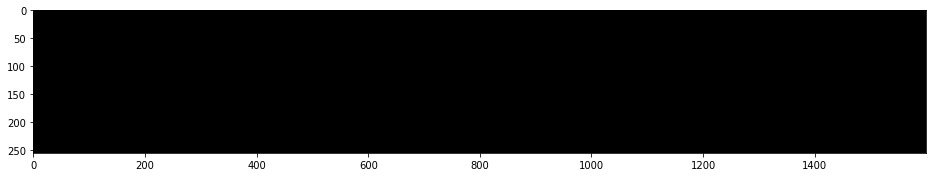

02d3ca489 1 TEST 0


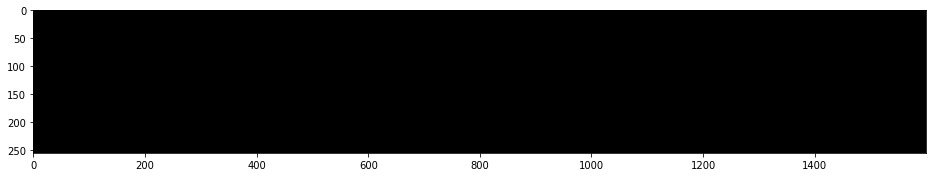

02d3ca489 2 REF


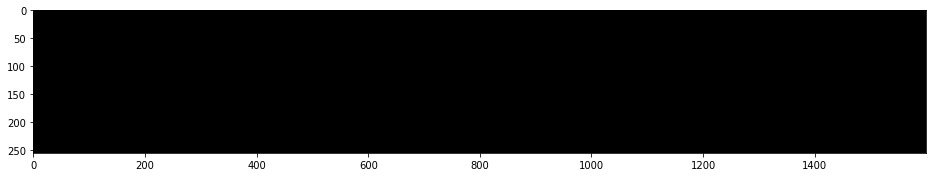

02d3ca489 2 TEST 0


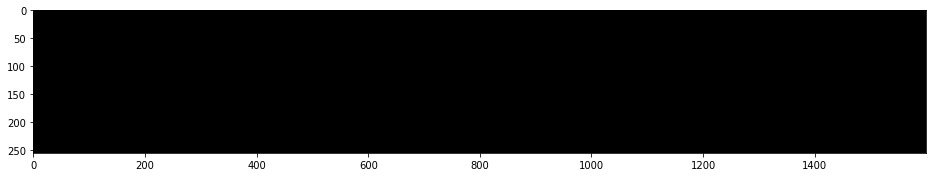

02d3ca489 3 REF


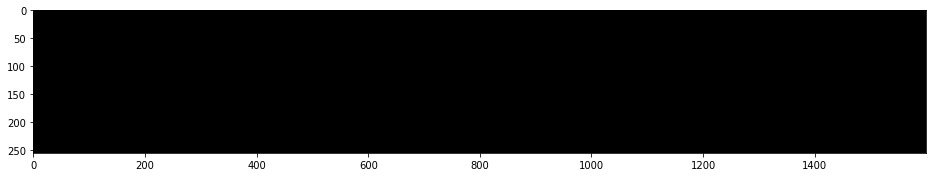

02d3ca489 3 TEST 409353


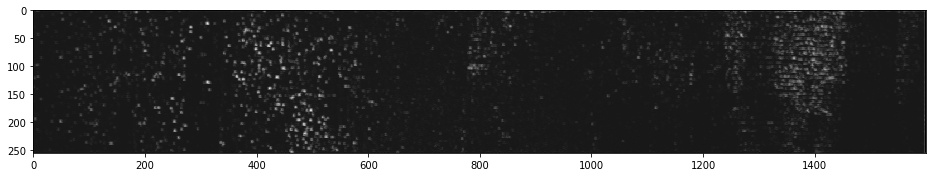

02d3ca489 4 REF


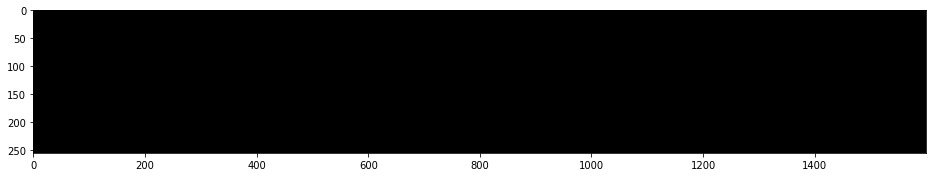

02d3ca489 4 TEST 0


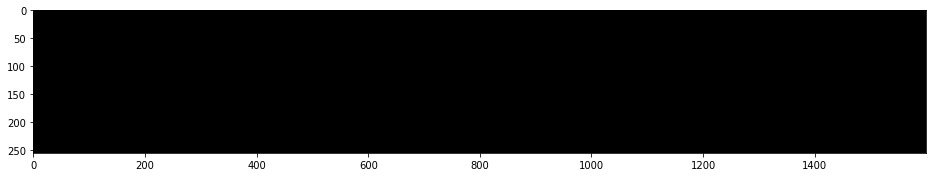

037fca267


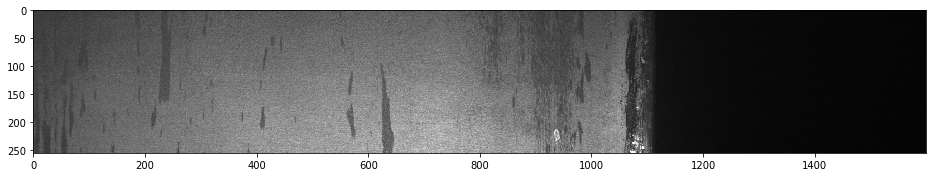

037fca267 1 REF


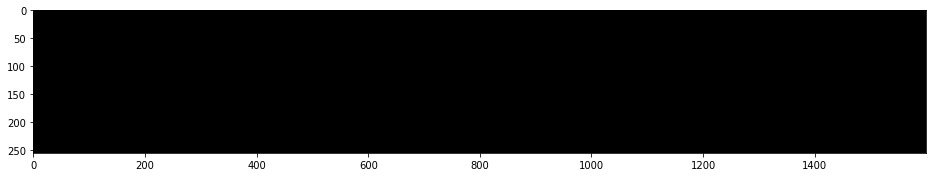

037fca267 1 TEST 0


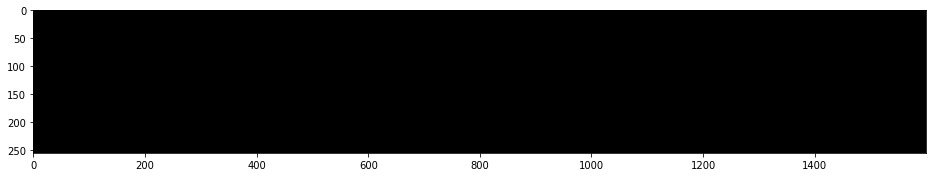

037fca267 2 REF


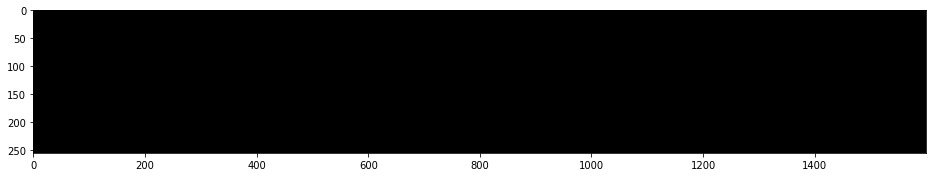

037fca267 2 TEST 0


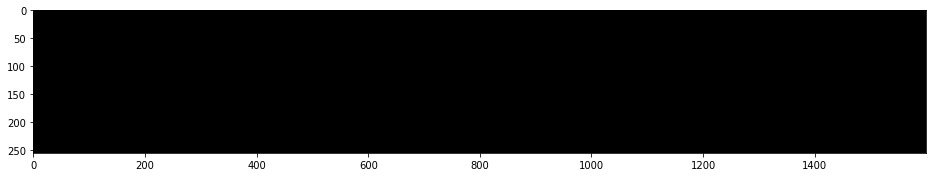

037fca267 3 REF


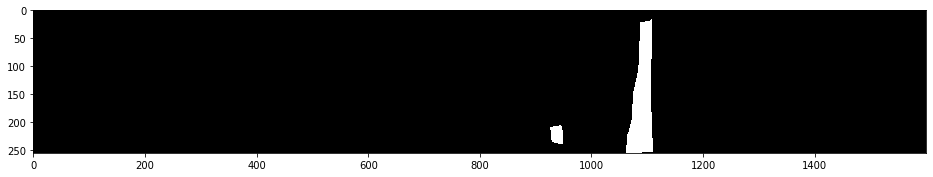

037fca267 3 TEST 300199


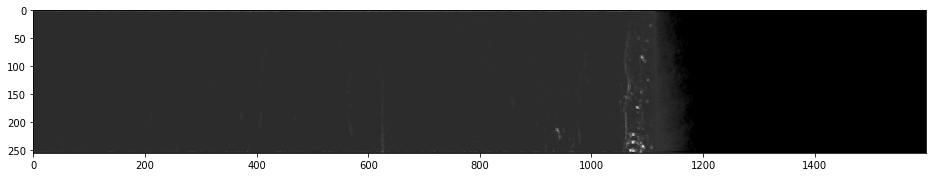

037fca267 4 REF


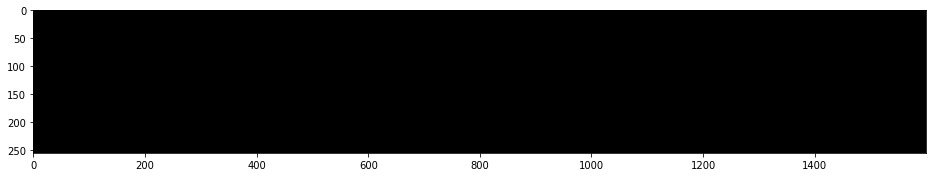

037fca267 4 TEST 0


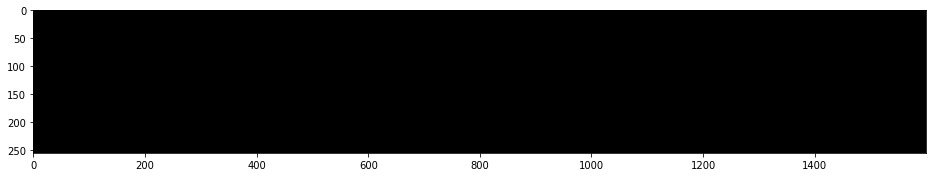

058f6a9c6


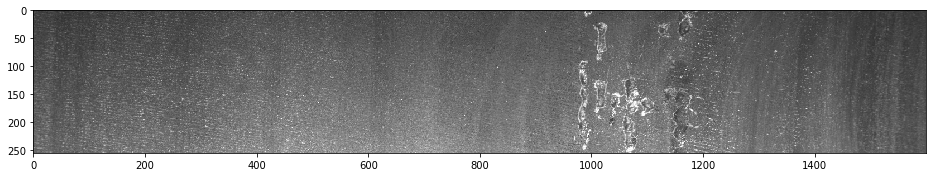

058f6a9c6 1 REF


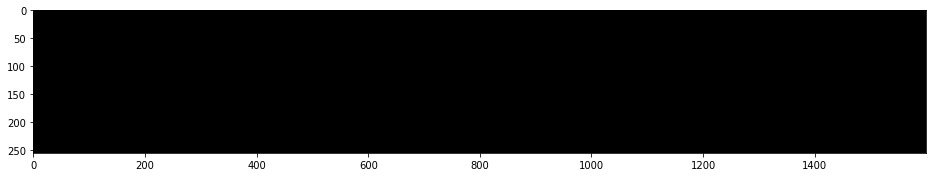

058f6a9c6 1 TEST 0


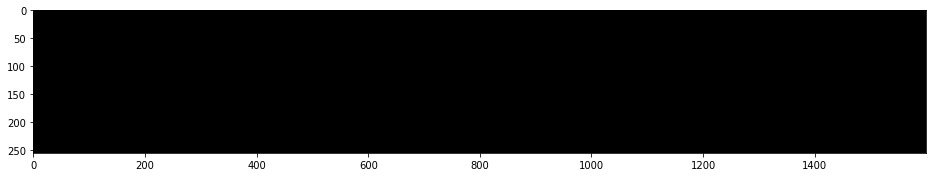

058f6a9c6 2 REF


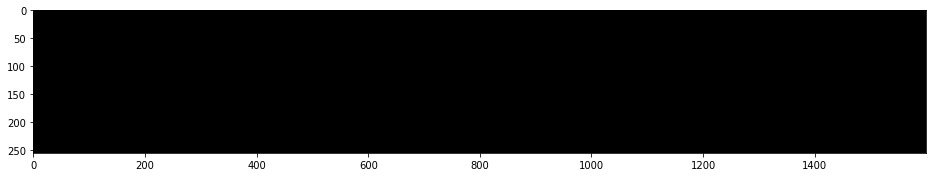

058f6a9c6 2 TEST 0


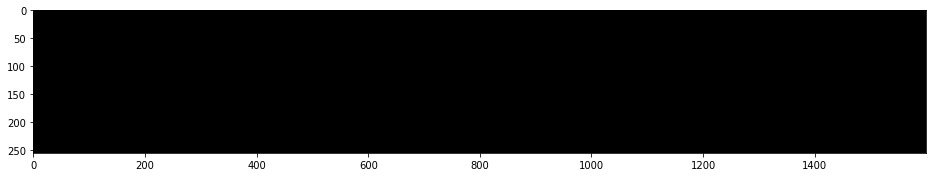

058f6a9c6 3 REF


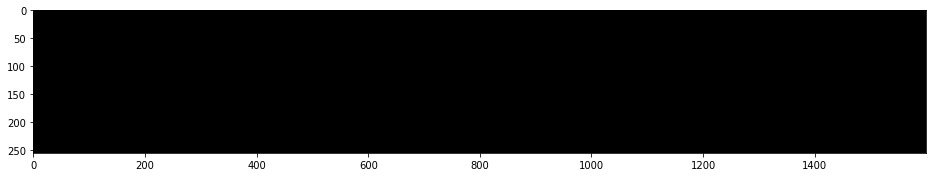

058f6a9c6 3 TEST 409463


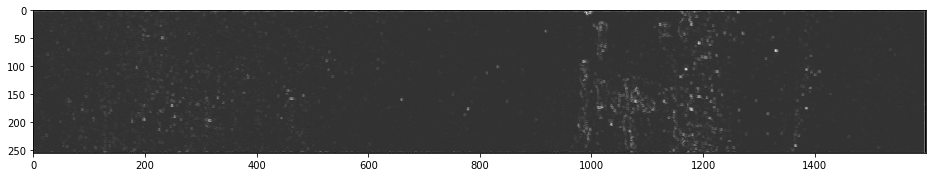

058f6a9c6 4 REF


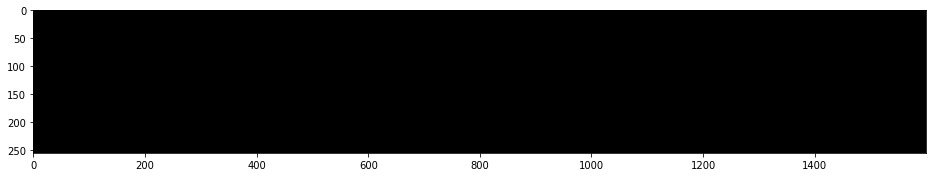

058f6a9c6 4 TEST 0


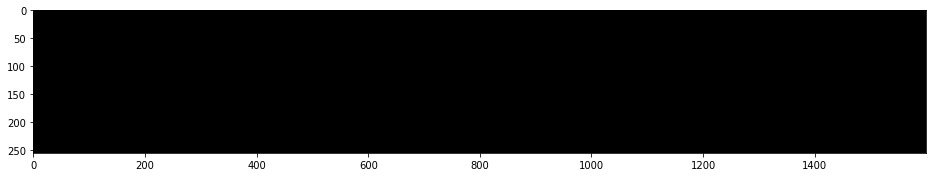

0cb590f8e


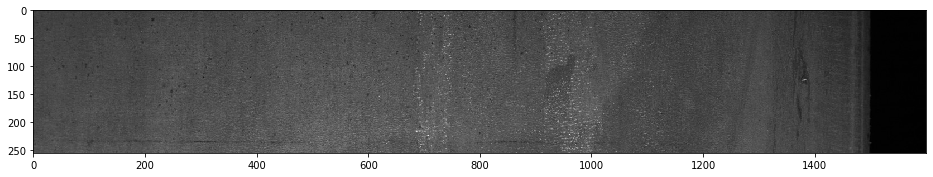

0cb590f8e 1 REF


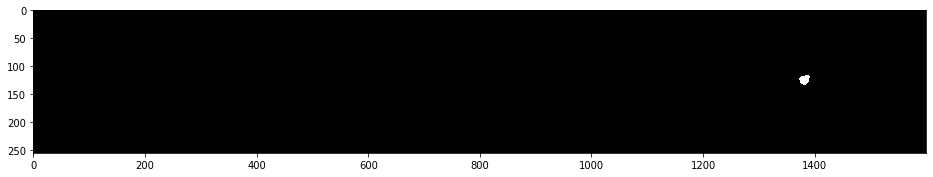

0cb590f8e 1 TEST 241


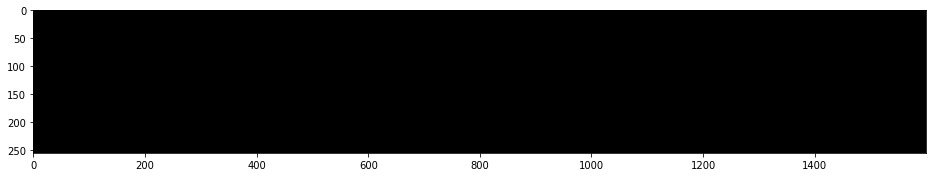

0cb590f8e 2 REF


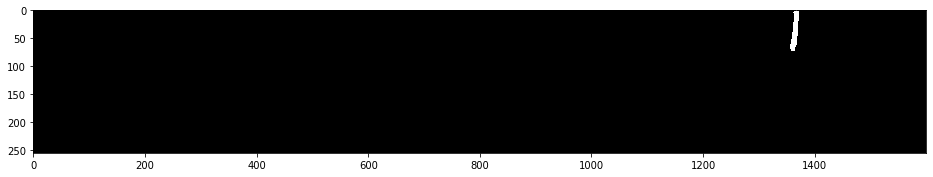

0cb590f8e 2 TEST 673


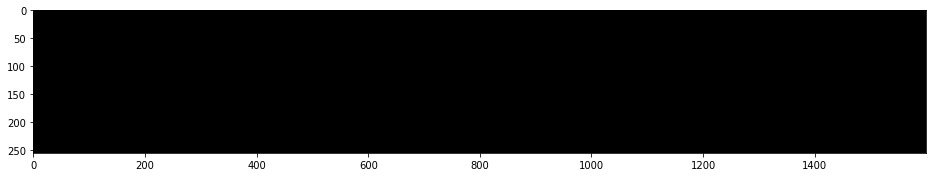

0cb590f8e 3 REF


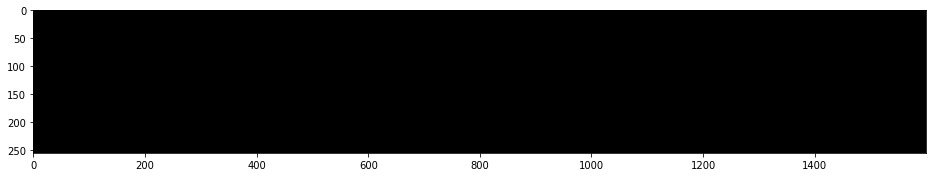

0cb590f8e 3 TEST 384008


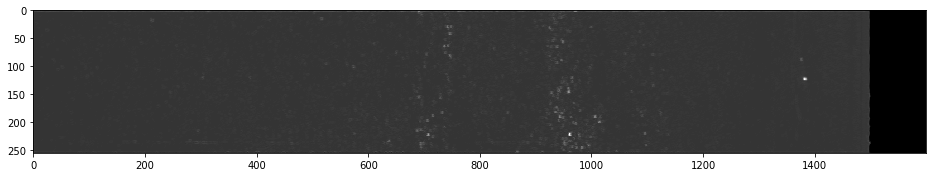

0cb590f8e 4 REF


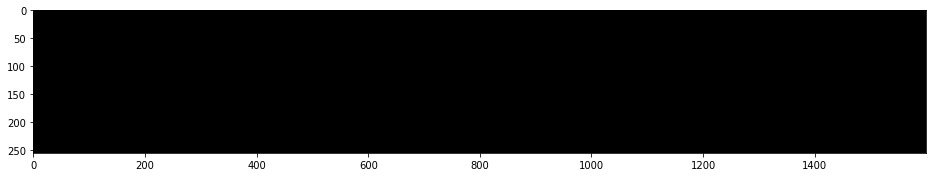

0cb590f8e 4 TEST 0


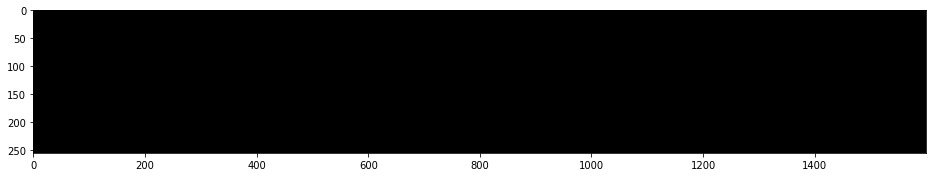

0c888ecb5


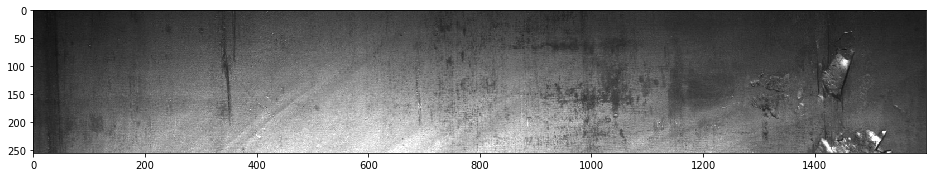

0c888ecb5 1 REF


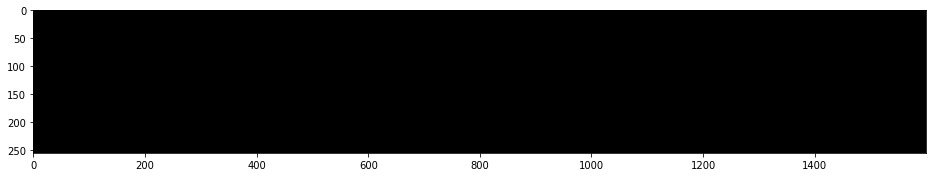

0c888ecb5 1 TEST 0


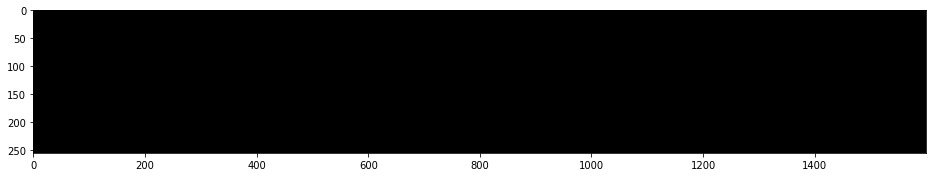

0c888ecb5 2 REF


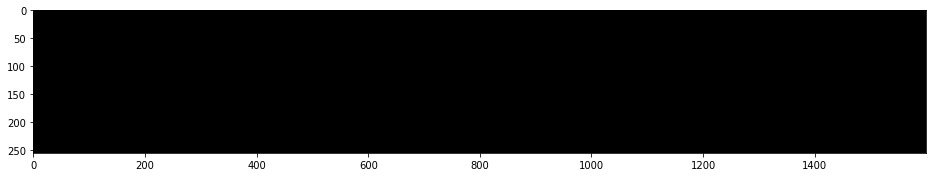

0c888ecb5 2 TEST 0


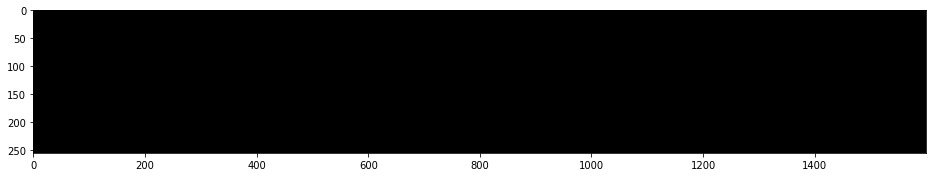

0c888ecb5 3 REF


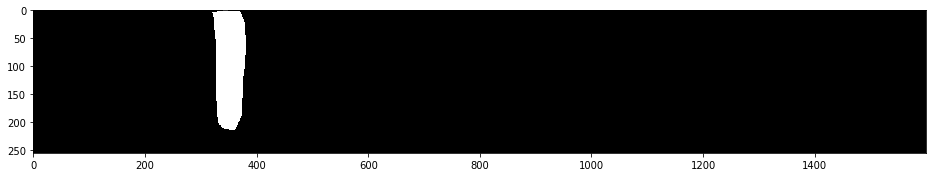

0c888ecb5 3 TEST 409583


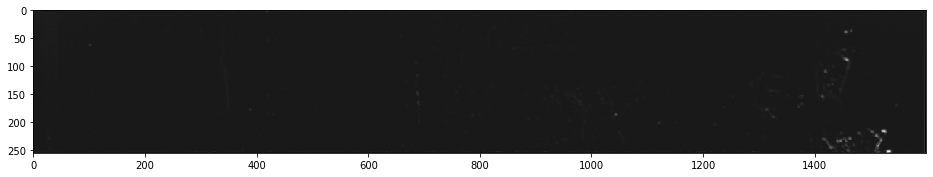

0c888ecb5 4 REF


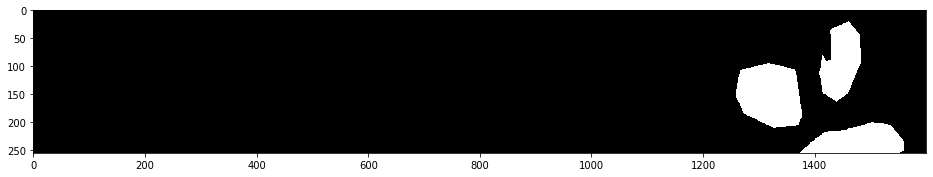

0c888ecb5 4 TEST 25346


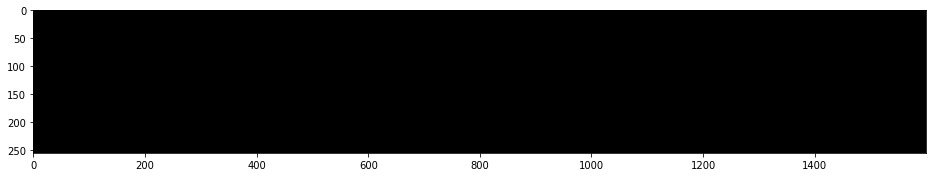

13cf44f8d


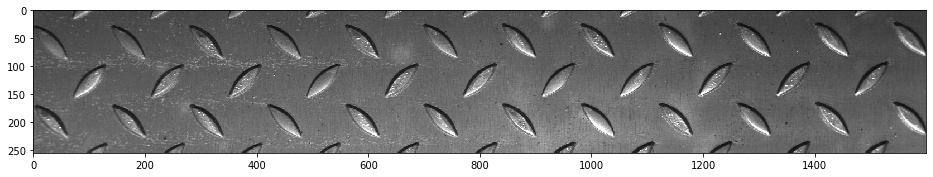

13cf44f8d 1 REF


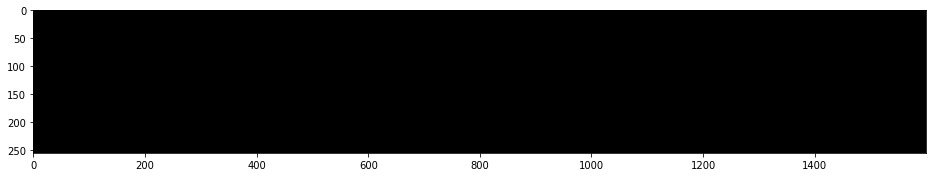

13cf44f8d 1 TEST 0


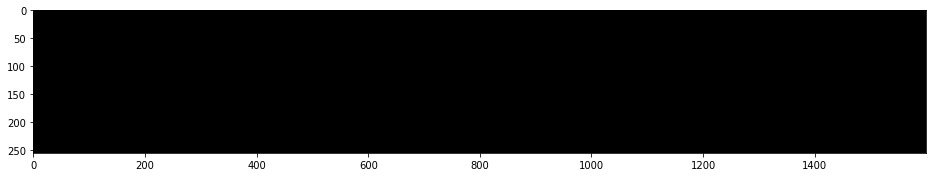

13cf44f8d 2 REF


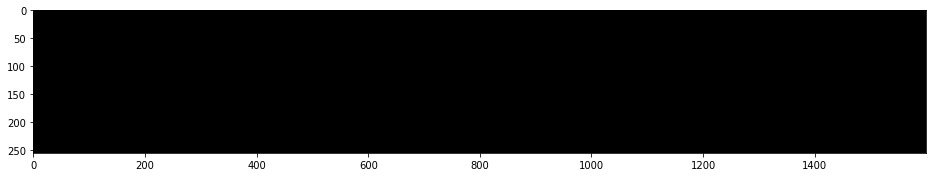

13cf44f8d 2 TEST 0


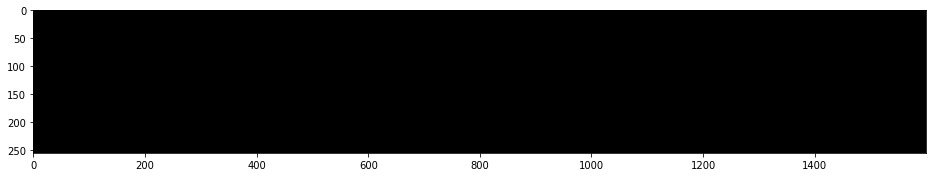

13cf44f8d 3 REF


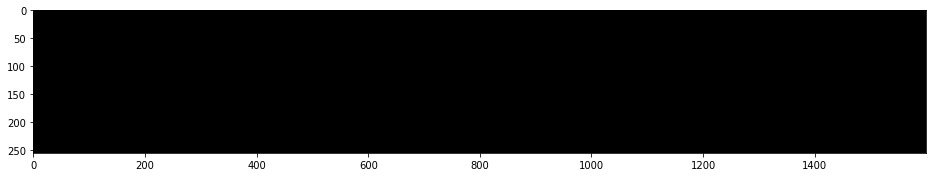

13cf44f8d 3 TEST 409447


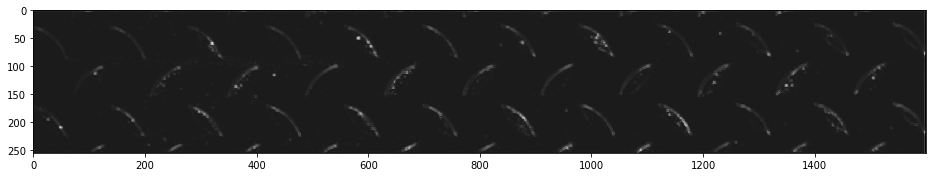

13cf44f8d 4 REF


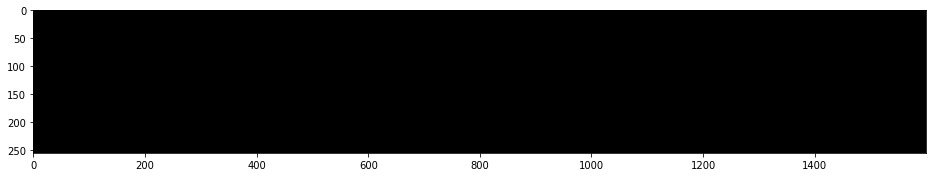

13cf44f8d 4 TEST 0


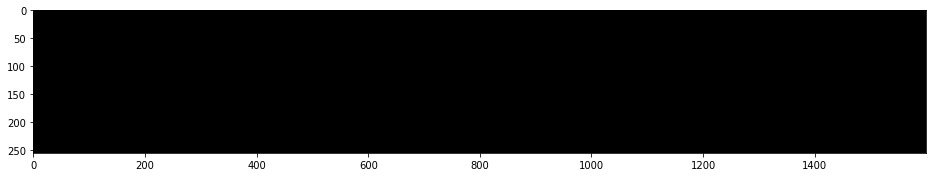

04072b39a


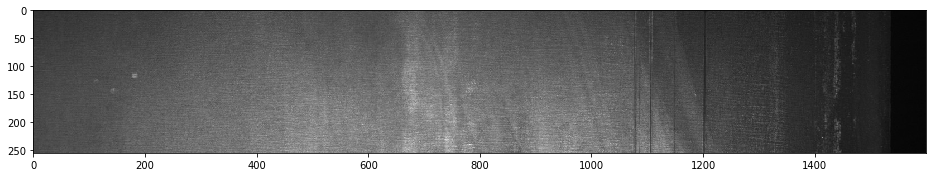

04072b39a 1 REF


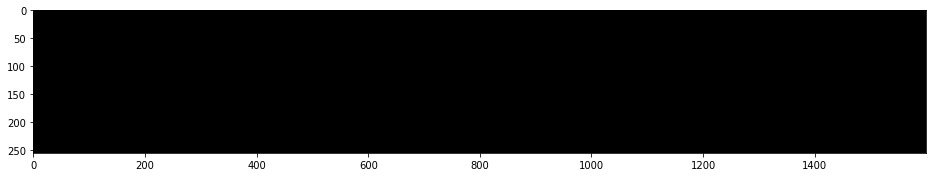

04072b39a 1 TEST 0


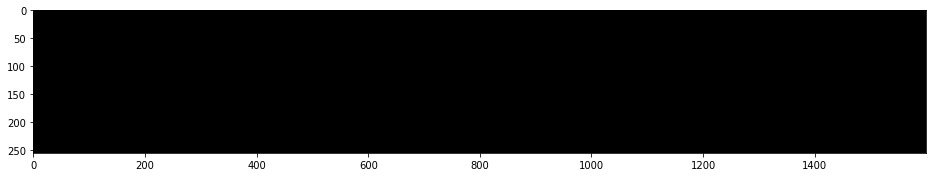

04072b39a 2 REF


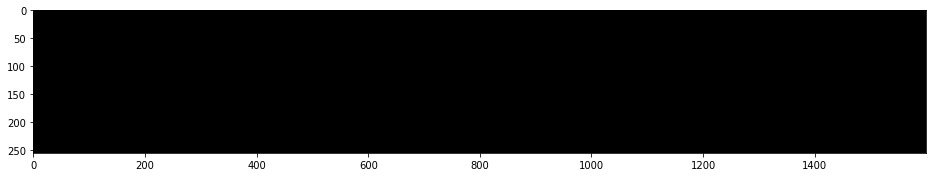

04072b39a 2 TEST 0


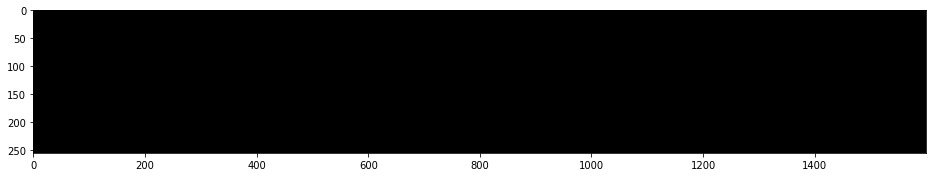

04072b39a 3 REF


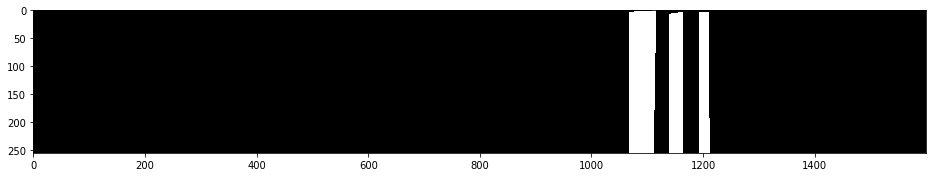

04072b39a 3 TEST 393731


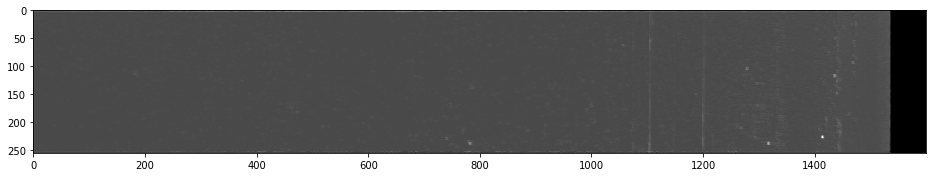

04072b39a 4 REF


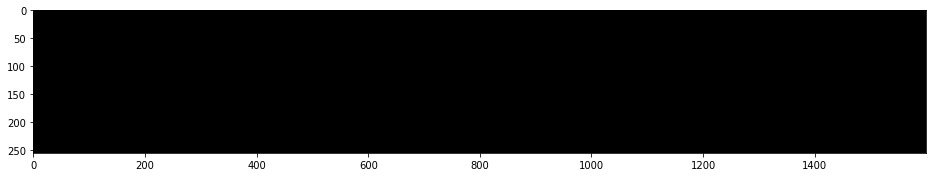

04072b39a 4 TEST 0


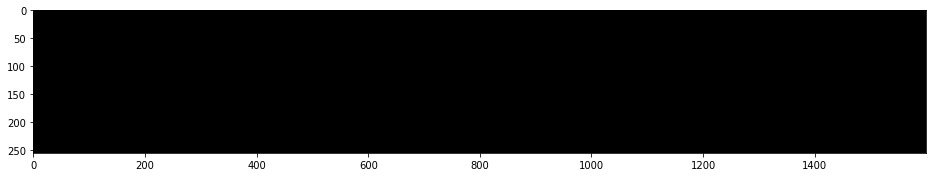

07cbfd1f8


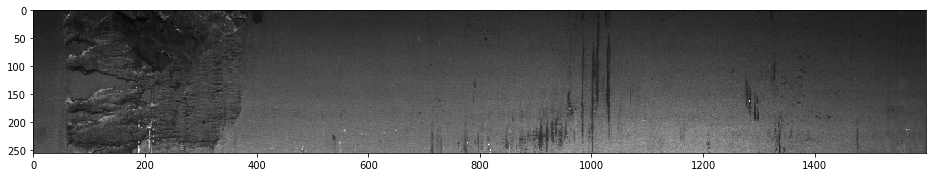

07cbfd1f8 1 REF


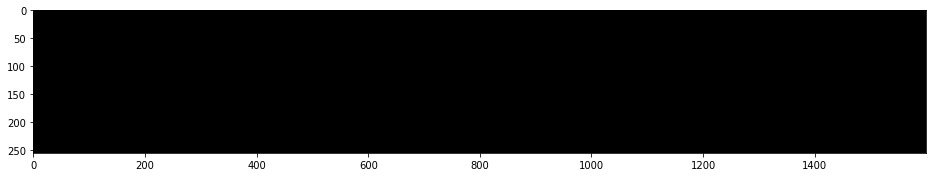

07cbfd1f8 1 TEST 0


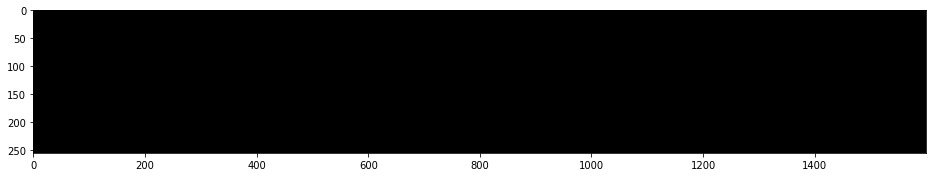

07cbfd1f8 2 REF


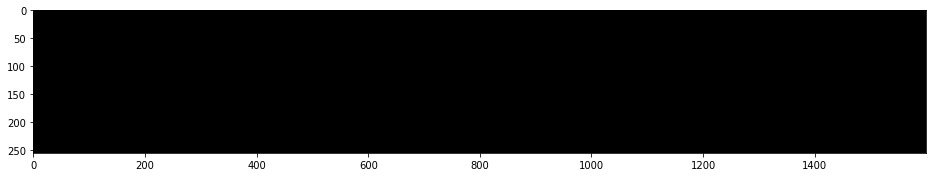

07cbfd1f8 2 TEST 0


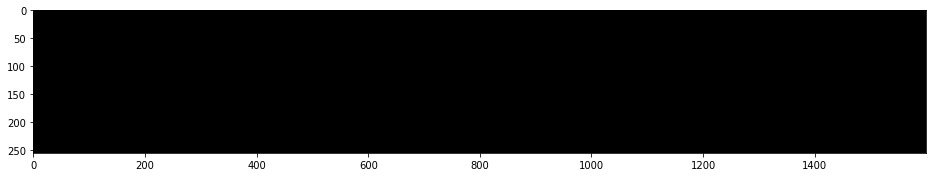

07cbfd1f8 3 REF


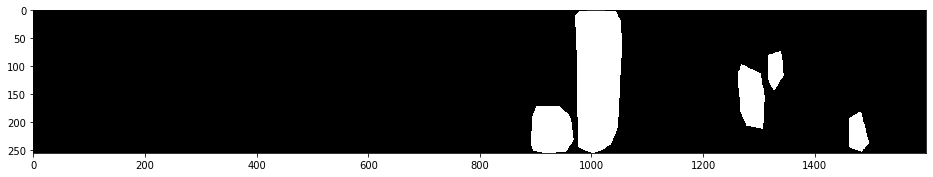

07cbfd1f8 3 TEST 409243


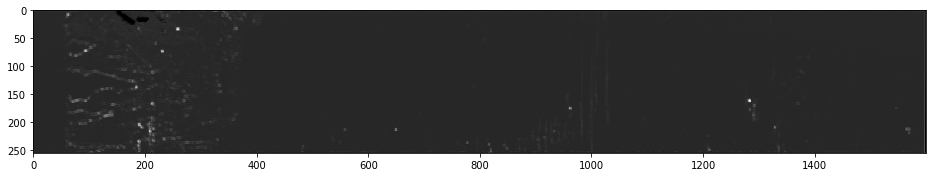

07cbfd1f8 4 REF


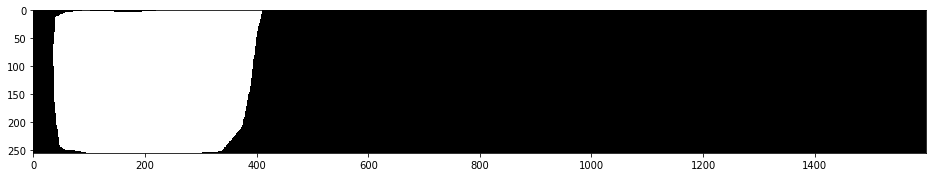

07cbfd1f8 4 TEST 87867


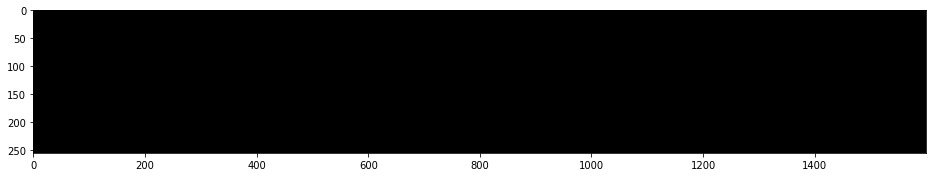

In [32]:
for i, name in enumerate(names):
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')
    im /= 255
    
    print(name)
    plt.figure(figsize=(16, 3))
    plt.imshow(im, cmap='gray')
    plt.show()
    
    for j in [1, 2, 3, 4]:
        rows = data[(data.imageid == name) & (data.classid == j)]
        row = rows.iloc[0, :]

        if row.mask_present:
            mask_ref = image_masks[f'{name}_{j}']
        else:
            mask_ref = np.zeros((HEIGHT, WIDTH), dtype='uint8')
            
        print(name, j, 'REF')
        plt.figure(figsize=(16, 3))
        plt.imshow(mask_ref, cmap='gray')
        plt.show()
        
        mask_test = results[j - 1][i].squeeze()
        #mask_test = (mask_test > 0.5).astype('uint8')
        
        
        print(name, j, 'TEST', np.sum(mask_ref != mask_test))
        plt.figure(figsize=(16, 3))
        plt.imshow(mask_test, cmap='gray')
        plt.show()
